# Read this section importantly!

In [ ]:
!nvidia-smi

Wed May 17 16:23:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q  torchsummaryX

In [ ]:
# # pip install transformers --quiet
# !pip install torch pytorch-lightning pytorch_forecasting -q

In [ ]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torchvision.transforms as tvt
import torchaudio.transforms as tat
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
import gc

import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime
# from pytorch_forecasting import TimeSeriesDataSet

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda
Device:  cuda


### **Read Pickle**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/")

In [ ]:
# import pickle
# F=open(r"day_raw.pkl","rb")
# data=pickle.load(F)

df = pd.read_pickle("day_raw.pkl")

In [ ]:
# df=pd.DataFrame(data)

In [ ]:
df

,code,date,open,high,low,close,volume,amount,return,zscore return,...,vola_vo_10,vola_vo_11,vola_vo_8,vola_vo_9,volu_tu_1,volu_tu_2,volu_tu_3,volu_vo_4,volu_vo_5,volu_vo_6
0,1,20170411,9.17,9.19,9.09,9.15,612438.00,5.603808e+06,-0.005459,0.125602,...,0.054300,-0.051272,-0.044613,-0.012875,0.036118,0.051287,0.048243,-0.042598,-0.026689,-0.027421
1,1,20170412,9.16,9.17,9.10,9.12,455337.00,4.152673e+06,0.000000,-0.133498,...,0.050729,-0.046772,-0.040157,-0.018649,0.015780,0.043548,0.042953,-0.044524,-0.042971,-0.044513
2,1,20170413,9.11,9.14,9.10,9.12,357443.00,3.259880e+06,-0.003293,0.733423,...,0.047585,-0.043945,-0.036590,0.005086,0.019514,0.027605,0.041537,-0.040943,-0.028323,-0.027111
3,1,20170414,9.11,9.12,9.06,9.08,490501.00,4.453749e+06,0.001101,0.479182,...,0.047237,-0.043021,-0.036808,-0.001414,0.022674,0.024235,0.041271,-0.043958,-0.018463,-0.020162
4,1,20170417,9.08,9.11,9.05,9.10,531892.00,4.840217e+06,-0.006601,0.255075,...,0.046918,-0.039582,-0.031640,0.002031,0.039221,0.034564,0.035085,-0.030394,-0.002333,-0.004934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4923346,689009,20220810,57.00,58.35,56.58,58.10,28896.14,1.678866e+06,-0.006867,-0.511415,...,0.123874,-0.125581,-0.123288,-0.025907,-0.140679,-0.163857,-0.169002,0.055672,-0.050692,0.006372
4923347,689009,20220811,58.25,58.70,55.80,56.99,35738.59,2.036742e+06,-0.023336,-0.368079,...,0.128801,-0.144976,-0.144993,0.026017,-0.168493,-0.161513,-0.178983,0.043391,-0.022395,0.056225
4923348,689009,20220812,57.85,58.97,56.65,57.00,22631.71,1.290007e+06,-0.061947,-2.208612,...,0.145057,-0.149965,-0.145380,0.004684,-0.143864,-0.160612,-0.170043,0.093004,0.020617,0.084528
4923349,689009,20220815,56.50,58.00,54.53,54.55,38270.32,2.087646e+06,0.018679,0.489422,...,0.147471,-0.144805,-0.117967,0.082816,-0.111777,-0.151383,-0.156305,0.079869,0.104901,0.141385


In [ ]:
# df['code'].nunique()
for i in df.columns:
  print(i)

code
date
open
high
low
close
volume
amount
return
zscore return
alph_al_1
alph_al_2
alph_al_3
alph_al_4
alph_al_5
alph_al_6
alph_al_7
dail_br_1
dail_br_2
dail_is_3
fu_1
fu_1.1
fu_1.2
fu_1.3
fu_1.4
fu_1.5
fu_1.6
fu_1.7
fu_1.8
fu_1.9
fu_1.10
fu_1.11
fu_1.12
fu_1.13
fu_1.14
fu_1.15
fu_1.16
fu_1.17
fu_1.18
fu_1.19
fu_1.20
fu_1.21
fu_1.22
fu_1.23
fu_1.24
fu_1.25
fu_1.26
fu_1.27
in_1
in_1.1
in_1.2
in_1.3
in_1.4
in_1.5
in_1.6
in_1.7
in_1.8
in_1.9
in_1.10
in_1.11
in_1.12
in_1.13
plat_pl_1
plat_pl_2
plat_pl_3
plat_pl_4
plat_pl_5
plat_pl_6
plat_pl_7
plat_pl_8
plat_to_9
stoc_IL_1
stoc_QV_2
stoc_cl_3
stoc_op_4
stoc_pr_5
stoc_vo_6
stoc_vo_6.1
stoc_vo_6.2
tick_am_1
tick_bu_2
tick_sa_3
tick_ti_4
tick_vo_5
unsu_CN_1
unsu_CN_2
unsu_CN_3
unsu_VA_4
unsu_VA_5
unsu_VA_6
unsu_VA_7
vola_re_1
vola_re_2
vola_re_3
vola_re_4
vola_st_5
vola_st_6
vola_st_7
vola_vo_10
vola_vo_11
vola_vo_8
vola_vo_9
volu_tu_1
volu_tu_2
volu_tu_3
volu_vo_4
volu_vo_5
volu_vo_6


### **Dummy**

In [ ]:
enc_code=OrdinalEncoder()
df['code']=enc_code.fit_transform(np.array(df['code']).reshape(-1,1) )
df

,code,date,open,high,low,close,volume,amount,return,zscore return,...,vola_vo_10,vola_vo_11,vola_vo_8,vola_vo_9,volu_tu_1,volu_tu_2,volu_tu_3,volu_vo_4,volu_vo_5,volu_vo_6
0,0.0,20170411,9.17,9.19,9.09,9.15,612438.00,5.603808e+06,-0.005459,0.125602,...,0.054300,-0.051272,-0.044613,-0.012875,0.036118,0.051287,0.048243,-0.042598,-0.026689,-0.027421
1,0.0,20170412,9.16,9.17,9.10,9.12,455337.00,4.152673e+06,0.000000,-0.133498,...,0.050729,-0.046772,-0.040157,-0.018649,0.015780,0.043548,0.042953,-0.044524,-0.042971,-0.044513
2,0.0,20170413,9.11,9.14,9.10,9.12,357443.00,3.259880e+06,-0.003293,0.733423,...,0.047585,-0.043945,-0.036590,0.005086,0.019514,0.027605,0.041537,-0.040943,-0.028323,-0.027111
3,0.0,20170414,9.11,9.12,9.06,9.08,490501.00,4.453749e+06,0.001101,0.479182,...,0.047237,-0.043021,-0.036808,-0.001414,0.022674,0.024235,0.041271,-0.043958,-0.018463,-0.020162
4,0.0,20170417,9.08,9.11,9.05,9.10,531892.00,4.840217e+06,-0.006601,0.255075,...,0.046918,-0.039582,-0.031640,0.002031,0.039221,0.034564,0.035085,-0.030394,-0.002333,-0.004934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4923346,4643.0,20220810,57.00,58.35,56.58,58.10,28896.14,1.678866e+06,-0.006867,-0.511415,...,0.123874,-0.125581,-0.123288,-0.025907,-0.140679,-0.163857,-0.169002,0.055672,-0.050692,0.006372
4923347,4643.0,20220811,58.25,58.70,55.80,56.99,35738.59,2.036742e+06,-0.023336,-0.368079,...,0.128801,-0.144976,-0.144993,0.026017,-0.168493,-0.161513,-0.178983,0.043391,-0.022395,0.056225
4923348,4643.0,20220812,57.85,58.97,56.65,57.00,22631.71,1.290007e+06,-0.061947,-2.208612,...,0.145057,-0.149965,-0.145380,0.004684,-0.143864,-0.160612,-0.170043,0.093004,0.020617,0.084528
4923349,4643.0,20220815,56.50,58.00,54.53,54.55,38270.32,2.087646e+06,0.018679,0.489422,...,0.147471,-0.144805,-0.117967,0.082816,-0.111777,-0.151383,-0.156305,0.079869,0.104901,0.141385


In [ ]:
enc_date=OrdinalEncoder()
df['date']=enc_date.fit_transform(np.array(df['date']).reshape(-1,1) )
df

,code,date,open,high,low,close,volume,amount,return,zscore return,...,vola_vo_10,vola_vo_11,vola_vo_8,vola_vo_9,volu_tu_1,volu_tu_2,volu_tu_3,volu_vo_4,volu_vo_5,volu_vo_6
0,0.0,0.0,9.17,9.19,9.09,9.15,612438.00,5.603808e+06,-0.005459,0.125602,...,0.054300,-0.051272,-0.044613,-0.012875,0.036118,0.051287,0.048243,-0.042598,-0.026689,-0.027421
1,0.0,1.0,9.16,9.17,9.10,9.12,455337.00,4.152673e+06,0.000000,-0.133498,...,0.050729,-0.046772,-0.040157,-0.018649,0.015780,0.043548,0.042953,-0.044524,-0.042971,-0.044513
2,0.0,2.0,9.11,9.14,9.10,9.12,357443.00,3.259880e+06,-0.003293,0.733423,...,0.047585,-0.043945,-0.036590,0.005086,0.019514,0.027605,0.041537,-0.040943,-0.028323,-0.027111
3,0.0,3.0,9.11,9.12,9.06,9.08,490501.00,4.453749e+06,0.001101,0.479182,...,0.047237,-0.043021,-0.036808,-0.001414,0.022674,0.024235,0.041271,-0.043958,-0.018463,-0.020162
4,0.0,4.0,9.08,9.11,9.05,9.10,531892.00,4.840217e+06,-0.006601,0.255075,...,0.046918,-0.039582,-0.031640,0.002031,0.039221,0.034564,0.035085,-0.030394,-0.002333,-0.004934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4923346,4643.0,1299.0,57.00,58.35,56.58,58.10,28896.14,1.678866e+06,-0.006867,-0.511415,...,0.123874,-0.125581,-0.123288,-0.025907,-0.140679,-0.163857,-0.169002,0.055672,-0.050692,0.006372
4923347,4643.0,1300.0,58.25,58.70,55.80,56.99,35738.59,2.036742e+06,-0.023336,-0.368079,...,0.128801,-0.144976,-0.144993,0.026017,-0.168493,-0.161513,-0.178983,0.043391,-0.022395,0.056225
4923348,4643.0,1301.0,57.85,58.97,56.65,57.00,22631.71,1.290007e+06,-0.061947,-2.208612,...,0.145057,-0.149965,-0.145380,0.004684,-0.143864,-0.160612,-0.170043,0.093004,0.020617,0.084528
4923349,4643.0,1302.0,56.50,58.00,54.53,54.55,38270.32,2.087646e+06,0.018679,0.489422,...,0.147471,-0.144805,-0.117967,0.082816,-0.111777,-0.151383,-0.156305,0.079869,0.104901,0.141385


### **Technical Indicators(RSI, MACD, %K%D...)**

In [152]:
def technical_indicators(df):
  df['volume']=df['volume']/1000
  df_close=df['close']
  df_close=pd.DataFrame(df_close, columns=['close'])
  df11=df_close.reset_index()
  #RSI
  df11['change'] = df11['close'].diff()
  df['change']=df11['change']
    #SMA  #30days
  df['SMA10'] = df11['close'].rolling(10).mean()
    #EMA
  df11['EWMA30'] = df11['close'].ewm(span=10).mean()

  # df['delta']=(df['change']>0)*1.
  def rma(x, n):
      """Running moving average"""
      a = np.full_like(x, np.nan)
      a[n] = x[1:n+1].mean()
      for i in range(n+1, len(x)):
          a[i] = (a[i-1] * (n - 1) + x[i]) / n
      return a

  df11['gain'] = df11.change.mask(df11.change < 0, 0.0)
  df11['loss'] = -df11.change.mask(df11.change > 0, -0.0)
  df11['avg_gain'] = rma(df11.gain.to_numpy(), 14)        
  df11['avg_loss'] = rma(df11.loss.to_numpy(), 14)     
  df11['rs'] = df11.avg_gain / df11.avg_loss
  df11['rsi'] = 100 - (100 / (1 + df11.rs))

   #stochastic oscillator
  df['14-high'] = df['high'].rolling(14).max()
  df['14-low'] = df['low'].rolling(14).min()
  df['%K'] = (df['close'] - df['14-low'])*100/(df['14-high'] - df['14-low'])
  df['%D'] = df['%K'].rolling(3).mean() 

  #MACD
  k = df['close'].ewm(span=12, adjust=False, min_periods=12).mean()
  d = df['close'].ewm(span=26, adjust=False, min_periods=26).mean()
  macd = k - d
  macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
  macd_h = macd - macd_s

  df['macd'] = df.index.map(macd)
  df['macd_h'] = df.index.map(macd_h)
  df['macd_s'] = df.index.map(macd_s)
    #A/D
  df['cmfv'] = ((df['close']-df['low'])-(df['high']-df['close']))/df['high']-df['low']*df['volume']
  # df['A/D'] = df['cmfv'].cumsum()/1000

    #OBV
  # df['obv'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()

  #ROC
  N=df['close'].diff(13)
  D=df['close'].shift(13)
  df['ROC'] = pd.Series(100*N/D)

  #william R
  highh = df['high'].rolling(14).max() 
  lowl = df['low'].rolling(14).min()
  df['wr'] = -100 * ((highh - df['close']) / (highh - lowl))

  #disparity index
  ma = df['close'].rolling(14).mean()
  df['disparity'] = ((df['close'] - ma) / ma) * 1000


  df11.drop(columns=['close','change','index','gain','loss','avg_gain','avg_loss','rs'], inplace=True)
  df_cat=pd.concat([df, df11], axis=1)
  df_cat.fillna(method='bfill', axis=0, inplace=True)
  df_cat.fillna(method='ffill', axis=0, inplace=True)
  return df_cat


In [ ]:
# df[df['code']==1].date
# count=df['code'].value_counts()
# for i in count:
#   print(i)

In [154]:
df1=df.iloc[:100000]
df1

,code,date,open,high,low,close,volume,amount,return,zscore return,...,vola_vo_10,vola_vo_11,vola_vo_8,vola_vo_9,volu_tu_1,volu_tu_2,volu_tu_3,volu_vo_4,volu_vo_5,volu_vo_6
0,0.0,0.0,9.17,9.19,9.09,9.15,612438.0,5603807.70,-0.005459,0.125602,...,0.054300,-0.051272,-0.044613,-0.012875,0.036118,0.051287,0.048243,-0.042598,-0.026689,-0.027421
1,0.0,1.0,9.16,9.17,9.10,9.12,455337.0,4152673.44,0.000000,-0.133498,...,0.050729,-0.046772,-0.040157,-0.018649,0.015780,0.043548,0.042953,-0.044524,-0.042971,-0.044513
2,0.0,2.0,9.11,9.14,9.10,9.12,357443.0,3259880.16,-0.003293,0.733423,...,0.047585,-0.043945,-0.036590,0.005086,0.019514,0.027605,0.041537,-0.040943,-0.028323,-0.027111
3,0.0,3.0,9.11,9.12,9.06,9.08,490501.0,4453749.08,0.001101,0.479182,...,0.047237,-0.043021,-0.036808,-0.001414,0.022674,0.024235,0.041271,-0.043958,-0.018463,-0.020162
4,0.0,4.0,9.08,9.11,9.05,9.10,531892.0,4840217.20,-0.006601,0.255075,...,0.046918,-0.039582,-0.031640,0.002031,0.039221,0.034564,0.035085,-0.030394,-0.002333,-0.004934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,78.0,956.0,4.38,4.44,4.37,4.40,32005.0,140822.00,-0.002273,-0.446968,...,0.311855,-0.301659,-0.281535,-0.077671,-0.348496,-0.353882,-0.324306,-0.344628,-0.556088,-0.492483
99996,78.0,957.0,4.40,4.44,4.34,4.39,29474.0,129390.86,0.025057,0.791834,...,0.294574,-0.345009,-0.359926,-0.036461,-0.383422,-0.377893,-0.364381,-0.382571,-0.644471,-0.371674
99997,78.0,958.0,4.39,4.51,4.35,4.50,56132.0,252594.00,-0.004444,0.068498,...,0.309833,-0.327917,-0.281279,0.148806,-0.126807,-0.292858,-0.326300,-0.327569,0.360170,1.207743
99998,78.0,959.0,4.50,4.50,4.43,4.49,56179.0,252243.71,-0.049107,-2.006317,...,0.348006,-0.339080,-0.297151,0.065208,-0.158820,-0.229639,-0.290377,-0.353784,0.277093,0.712040


In [155]:
df1=technical_indicators(df1)

In [157]:
df1.amount/=10000
df1

,code,date,open,high,low,close,volume,amount,return,zscore return,...,%D,macd,macd_h,macd_s,cmfv,ROC,wr,disparity,EWMA30,rsi
0,0.0,0.0,9.17,9.19,9.09,9.15,612.438,560.380770,-0.005459,0.125602,...,19.730159,-0.075529,0.058314,-0.039538,-5567.059244,-1.748634,-66.666667,-3.483769,9.150000,30.909091
1,0.0,1.0,9.16,9.17,9.10,9.12,455.337,415.267344,0.000000,-0.133498,...,19.730159,-0.075529,0.058314,-0.039538,-4143.569972,-1.748634,-66.666667,-3.483769,9.133500,30.909091
2,0.0,2.0,9.11,9.14,9.10,9.12,357.443,325.988016,-0.003293,0.733423,...,19.730159,-0.075529,0.058314,-0.039538,-3252.731300,-1.748634,-66.666667,-3.483769,9.128073,30.909091
3,0.0,3.0,9.11,9.12,9.06,9.08,490.501,445.374908,0.001101,0.479182,...,19.730159,-0.075529,0.058314,-0.039538,-4443.941253,-1.748634,-66.666667,-3.483769,9.112235,30.909091
4,0.0,4.0,9.08,9.11,9.05,9.10,531.892,484.021720,-0.006601,0.255075,...,19.730159,-0.075529,0.058314,-0.039538,-4813.618209,-1.748634,-66.666667,-3.483769,9.108723,30.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,78.0,956.0,4.38,4.44,4.37,4.40,32.005,14.082200,-0.002273,-0.446968,...,59.481481,0.102256,0.003343,0.098913,-139.864102,5.263158,-35.555556,19.698725,4.316862,64.039906
99996,78.0,957.0,4.40,4.44,4.34,4.39,29.474,12.939086,0.025057,0.791834,...,62.969854,0.101791,0.002303,0.099488,-127.917160,3.782506,-39.534884,13.856813,4.330160,63.181736
99997,78.0,958.0,4.39,4.51,4.35,4.50,56.132,25.259400,-0.004444,0.068498,...,70.318691,0.109042,0.007643,0.101399,-244.143158,5.140187,-13.953488,34.652652,4.361040,68.225741
99998,78.0,959.0,4.50,4.50,4.43,4.49,56.179,25.224371,-0.049107,-2.006317,...,76.744186,0.112682,0.009026,0.103656,-248.861859,4.906542,-16.279070,28.805237,4.384487,67.322786


In [158]:
list(df1.columns).index("SMA10")

109

### **Fit Which Column? Define Feature size**

In [159]:
CLOSE=109
FEATURE=123

In [160]:
df1.columns
# for i in df1.columns:
#   print(i)

Index(['code', 'date', 'open', 'high', 'low', 'close', 'volume', 'amount',
       'return', 'zscore return',
       ...
       '%D', 'macd', 'macd_h', 'macd_s', 'cmfv', 'ROC', 'wr', 'disparity',
       'EWMA30', 'rsi'],
      dtype='object', length=123)

### **Standardize**

In [161]:
#Normalize time series
Scaler = StandardScaler()
dataset = Scaler.fit_transform(df1)
dataset

array([[-1.71726533, -1.79758617, -0.22931388, ..., -0.04766376,
        -0.2326106 , -1.40974076],
       [-1.71726533, -1.79495177, -0.23024697, ..., -0.04766376,
        -0.23415584, -1.40974076],
       [-1.71726533, -1.79231738, -0.23491243, ..., -0.04766376,
        -0.23466407, -1.40974076],
       ...,
       [ 1.70912984,  0.72616409, -0.67533107, ...,  0.33690989,
        -0.68110021,  1.60780158],
       [ 1.70912984,  0.72879848, -0.66506707, ...,  0.27794364,
        -0.67890435,  1.53478575],
       [ 1.70912984,  0.73143288, -0.66693325, ...,  0.0500607 ,
        -0.6786402 ,  0.91585405]])

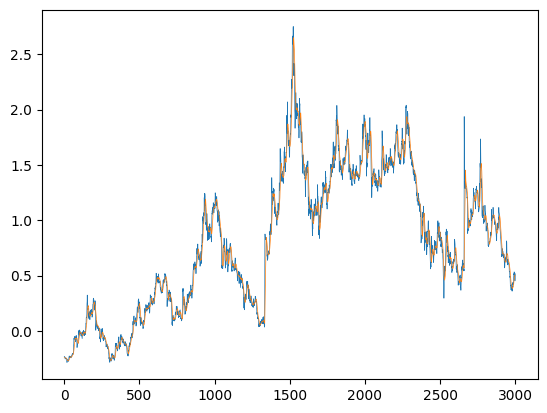

In [162]:
plt.plot(dataset[:3000,5], linewidth=0.5) #plot closing price
plt.plot(dataset[:3000,CLOSE], linewidth=0.5) #plot closing price

### **Train Test Split**

In [163]:
# dataset=np.array(APPL)
dataset=dataset.tolist()
a=int(0.9*len(dataset))
X_train=dataset[0:a]
X_test=dataset[a:]
print(len(X_train))
len(X_test)


90000


10000

In [ ]:
# CLOSE=5
# FEATURE=np.array(X_train).shape[-1]
# print("#Feature", FEATURE)

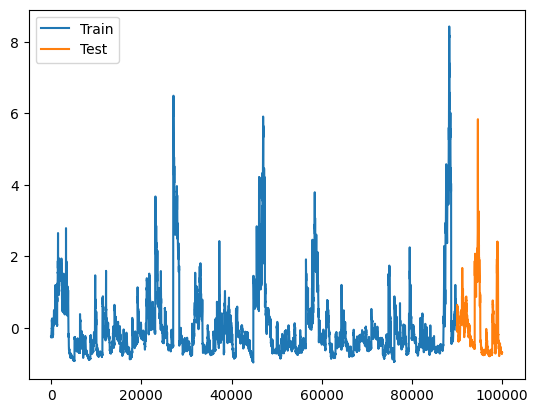

In [164]:
plt.plot(np.array(X_train)[:,CLOSE], label='Train' )
plt.plot(np.arange(len(X_train), len(X_train)+len(X_test)),np.array(X_test)[:,CLOSE], label='Test')
plt.legend()
plt.show()

In [ ]:
# data=dataset[]

In [165]:
#TODO: try to tune this
config = {
  'batch_size': 64,
  'lr':1e-4,
  'epochs': 30,
}

### **Dataset Dataloader**

In [187]:
class TransformerDataset(Dataset):
    def __init__(self, data, indices, enc_seq_len, pred_seq_len, step_size) :
        super().__init__()
        self.data = data
        self.indices = indices
        self.enc_seq_len = enc_seq_len
        self.pred_seq_len = pred_seq_len
        self.step_size=step_size

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        start, end = self.indices[index]
        
        sequence = self.data[start:end]

        src = sequence[:self.enc_seq_len]      #0~59 inclusive
        tgt = sequence[self.enc_seq_len-self.step_size+1 : self.enc_seq_len+1]     #56~60 inclusive
        true = sequence[self.enc_seq_len+1:]     #61～65 inclusive

        
        return src, tgt, true
    

In [188]:
def get_windows(data, window_size, step_size):
    start = 0
    end = window_size
    
    indices = []
    while end < len(data):      #proceed window by step size, count how many sequences 
        indices.append( (start, end) )
        start += step_size
        end += step_size
    return indices

In [ ]:
# plt.plot(np.array(X_train)[:,4])

torch.Size([128, 60, 123]) torch.Size([128, 10, 123]) torch.Size([128, 10, 123])
x:  tensor([-0.6831, -0.6821, -0.6821, -0.6814, -0.6812, -0.6813, -0.6809, -0.6801,
        -0.6795, -0.6783, -0.6767, -0.6759, -0.6752, -0.6749, -0.6743, -0.6737,
        -0.6740, -0.6753, -0.6773, -0.6790, -0.6804, -0.6814, -0.6821, -0.6826,
        -0.6829, -0.6830, -0.6820, -0.6816, -0.6806, -0.6798, -0.6790, -0.6785,
        -0.6779, -0.6770, -0.6765, -0.6757, -0.6757, -0.6742, -0.6734, -0.6727,
        -0.6724, -0.6723, -0.6721, -0.6731, -0.6738, -0.6742, -0.6734, -0.6733,
        -0.6729, -0.6725, -0.6718, -0.6714, -0.6708, -0.6694, -0.6679, -0.6673,
        -0.6671, -0.6681, -0.6692, -0.6706])
tgt:  tensor([-0.6714, -0.6708, -0.6694, -0.6679, -0.6673, -0.6671, -0.6681, -0.6692,
        -0.6706, -0.6751])
y_train:  tensor([-0.6803, -0.6860, -0.6914, -0.6968, -0.7024, -0.7073, -0.7072, -0.7074,
        -0.7071, -0.7025])


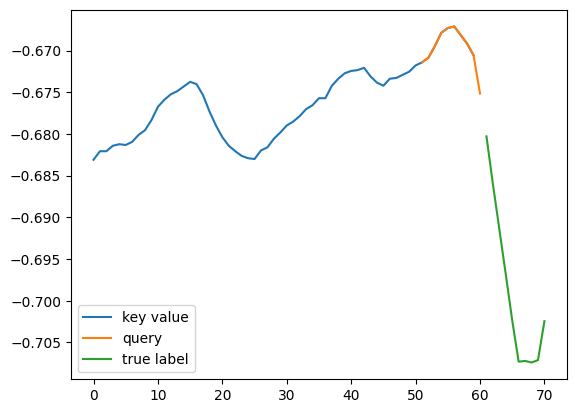

In [189]:
# Dataset Dataloader:
#TODO: tune context_len and pred_len
gc.collect()
context_len=60
pred_len=1
step_size=10
window_size=context_len+pred_len+step_size
training_indices = get_windows(X_train, window_size, step_size=step_size) #TODO: Tune step size... 
val_indices = get_windows(X_test, window_size, step_size=step_size) #TODO: Tune step size... 
test_indices = get_windows(X_test, window_size, step_size=step_size) 

test1_indices = get_windows(X_train[0:1000], window_size, step_size=step_size) 

# print(training_indices)
train_data=TransformerDataset(torch.FloatTensor(X_train), training_indices, context_len, pred_len, step_size) 
val_data=TransformerDataset(torch.FloatTensor(X_test), val_indices, context_len, pred_len, step_size) 
test_data=TransformerDataset(torch.FloatTensor(X_test), test_indices, context_len, pred_len, step_size) 

test1_data=TransformerDataset(torch.FloatTensor(X_train[0:1000]), test1_indices, context_len, pred_len, step_size) 
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data, 
    batch_size  = 128,
    shuffle=True,
    drop_last=True

)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data, 
    batch_size  = 24,
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data, 
    batch_size  = 24,
    shuffle=False,
    drop_last=True
)
test1_loader = torch.utils.data.DataLoader(
    dataset     = test1_data, 
    batch_size  = 1,
    shuffle=False
)

for batch in train_loader: 
    src, tgt, y_train=batch
    print(src.shape, tgt.shape, y_train.shape)
    print("x: ", src[0,:,CLOSE])   #30 days context  
    print("tgt: ", tgt[0,:,CLOSE]) #should be next 10 days 
    print("y_train: ", y_train[0,:,CLOSE])  #True label should shift by one to right
    plt.plot(src[0,:,CLOSE], label='key value')
    plt.plot(np.arange(context_len-step_size+1, context_len+1),tgt[0,:,CLOSE], label='query')
    plt.plot(np.arange(context_len+1, context_len+step_size+1),y_train[0,:,CLOSE], label='true label')
    plt.legend()
    plt.show()
    # plt.plot(src[1,:,3])
    # plt.plot(src[2,:,3]) #
    break

### **Positional Encoding & Transformer**

In [190]:
class PositionalEncoder(nn.Module):
    def __init__(self,  max_seq_len = 5000, d_model = 512, dropout= 0.1,):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        time = torch.arange(0, max_seq_len).unsqueeze(1)
        self.positional_encoding = torch.zeros(1,max_seq_len, d_model).to(DEVICE)
        xx= (torch.arange(0,max_seq_len).reshape(-1, 1).to(DEVICE)) / torch.pow(10000, torch.arange(0, d_model, 2)/d_model).to(DEVICE)
        self.positional_encoding[:, :, 0::2] = torch.sin(xx)
        self.positional_encoding[:, :, 1::2] = torch.cos(xx)

        self.register_buffer('pe', self.positional_encoding)

    def forward(self, x) :
        x = x + self.positional_encoding[:,:x.shape[1]]
        x=self.dropout(x)
        return x


In [191]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim=8, output_dim=1, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,encode_seq_len=60,pred_seq_len=10):
        super(TransformerEncoder, self).__init__()
        self.nhead=nhead
        self.d_model=d_model
        self.encode_seq_len=encode_seq_len
        self.embedding = nn.Linear(input_dim, d_model) 

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        # self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.pred_seq_len=pred_seq_len
        self.linear_out = nn.Linear(d_model, 1)
        self.positional_encoding_layer = PositionalEncoder(encode_seq_len, d_model, dropout  )

    def forward(self, x):
        # print("in,",x.shape) #32 10 29, batch len feature
        batch_size, seq_len, feature=x.shape

        # #encode x
        x = self.embedding(x) 
        x = self.positional_encoding_layer(x)

        encoder_out = self.encoder(x)
        out= self.linear_out(encoder_out[:, -1, :])
        # decoder_out = self.decoder(query, encoder_out,tgt_mask=tgt_mask, memory_mask=src_mask )
        # print("asdasdasdasdasd",decoder_out.shape)

        # attn_weights = self.decoder.layers[-1].multihead_attn.attn_output_weights

        # decoder_out = self.linear_out(decoder_out)
        
        return out


In [192]:
transformerEncoder=TransformerEncoder(input_dim=FEATURE, output_dim=1, d_model=512, nhead=2, 
                  num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=512, 
                  dropout=0.3, encode_seq_len=context_len, pred_seq_len=pred_len).to(device)


In [ ]:
PATH="/content/drive/MyDrive/stock_pretrain.pth"
checkpoint = torch.load(PATH)
transformerEncoder.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [193]:
class TransformerDecoder(nn.Module):
    def __init__(self,encoder:TransformerEncoder, input_dim=8, output_dim=1, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,encode_seq_len=60,pred_seq_len=10):
        super(TransformerDecoder, self).__init__()
        self.nhead=nhead
        self.d_model=d_model
        self.encode_seq_len=encode_seq_len
        self.embedding_query = nn.Linear(input_dim, d_model) 

        self.encoder = encoder
        # for param in encoder.parameters():
        #   param.requires_grad = False

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.pred_seq_len=pred_seq_len
        self.linear_final = nn.Linear(d_model*step_size*pred_len, FEATURE)
        self.positional_encoding_layer = PositionalEncoder(encode_seq_len, d_model, dropout  )

    def forward(self, x, query, tgt_mask=None, src_mask=None):
        # print("in,",x.shape) #32 10 29, batch len feature
        batch_size, seq_len, feature=x.shape

        # #encode x
        x = self.encoder.embedding(x) 
        x = self.encoder.positional_encoding_layer(x)
        encoder_out = self.encoder.encoder(x)

        # encoder_out = self.encoder(x)

        query=self.embedding_query(query)
        query=self.positional_encoding_layer(query)
        # print(query.shape)
        decoder_out = self.decoder(query, encoder_out,tgt_mask=tgt_mask, memory_mask=src_mask )

        # attn_weights = self.decoder.layers[-1].multihead_attn.attn_output_weights

        out = self.linear_final(decoder_out.flatten(1)).unsqueeze(1)
        
        return out


In [194]:
gc.collect()
torch.cuda.empty_cache()

In [195]:
#TODO: tune model parameters
model=TransformerDecoder(transformerEncoder, input_dim=FEATURE, output_dim=FEATURE, d_model=512, nhead=2, 
                  num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=512, 
                  dropout=0.3, encode_seq_len=context_len, pred_seq_len=max(pred_len,step_size)).to(device)
# print(x.size)
for x, tgt, y in train_loader: 
    x=torch.FloatTensor(x).to(device)
    tgt=torch.FloatTensor(tgt).to(device)
    y=torch.FloatTensor(y).to(device)
    print("x shape:", x.shape,"tgt shape:", tgt.shape, "y shape:", y.shape)
    out=model(x, tgt)
    
    print("out shape:", out.shape)
    summary(model, x, tgt)
    break
# print("context len:",model.encode_seq_len,"pred_len:", model.pred_seq_len)

x shape: torch.Size([128, 60, 123]) tgt shape: torch.Size([128, 10, 123]) y shape: torch.Size([128, 10, 123])
out shape: torch.Size([128, 1, 123])
                                                   Kernel Shape  \
Layer                                                             
0_encoder.Linear_embedding                           [123, 512]   
1_encoder.positional_encoding_layer.Dropout_dro...            -   
2_encoder.encoder.layers.0.Dropout_dropout1                   -   
3_encoder.encoder.layers.0.LayerNorm_norm1                [512]   
4_encoder.encoder.layers.0.Linear_linear1            [512, 512]   
5_encoder.encoder.layers.0.Dropout_dropout                    -   
6_encoder.encoder.layers.0.Linear_linear2            [512, 512]   
7_encoder.encoder.layers.0.Dropout_dropout2                   -   
8_encoder.encoder.layers.0.LayerNorm_norm2                [512]   
9_encoder.encoder.layers.1.Dropout_dropout1                   -   
10_encoder.encoder.layers.1.LayerNorm_norm1      

In [ ]:
PATH="/content/drive/MyDrive/stock_sft_teacher.pth"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Model Setup 

# Loss Function, Optimizers, Scheduler

In [196]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay=1e-3)
criterion   = torch.nn.HuberLoss() 
scaler      = torch.cuda.amp.GradScaler()

# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

# Train and Validation functions 


In [197]:
class Trainer():
  def __init__(self, model, loader,criterion, val_loader, test_loader):
    self.model      = model
    self.loader     = loader
    self.criterion  = criterion
    self.train_plot=[]
    self.teacher=True
    self.val_loader=val_loader
    self.test_loader=test_loader
    self.n_iters=0
    
  def train(self):
      teacher_forcing_rate=1.0
      
      self.model.train() # set to training mode
      self.model.to(device)

      batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(self.loader):
          self.n_iters+=1
          optimizer.zero_grad()
          src, trg, y_train = batch  

          src = src.to(device)    #batch, context, feat
          trg = trg.to(device)    #batch, 1, feat
          y_train = y_train.to(device)  #batch, pred, feat

          # batch_size = src.shape[0]
          next_token=None
          generated=trg.clone()

          for t in range(0, step_size):
            # teacher_forcing_rate=0
            p = np.random.random(1)# generate a probability p between 0 and 1
            if p < teacher_forcing_rate and t > 0: # Why do we consider cases only when t > 0? What is considered when t == 0? Think.
              
              next_token = y_train[:,t-1, :] # Take from y, else used token drawn from probability distribution
              generated[:,-1] = y_train[:,t-1, :]

            if t==0:
              y_pred = self.model(src, generated)
            else:

              # cats=torch.stack(generated, dim=1)
              y_pred = self.model(src, generated)

            next_token=y_pred

            generated=torch.cat([generated, next_token], dim=1)
            generated=generated[:,-step_size:]
            # generated.append(next_token.squeeze())

          generated=generated[:,-step_size:]

          loss = criterion(generated[:,:,CLOSE], y_train[:,:,CLOSE])*100    
          loss.backward()
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1e+6)
          optimizer.step()
          # scheduler.step()

          if self.n_iters %2 ==0:
            teacher_forcing_rate=max(teacher_forcing_rate-0.05, 0.1)
            if teacher_forcing_rate<=0.1:
              teacher_forcing_rate=0.9
          
          self.train_plot.append(loss.item())
          running_loss += loss.item()
          
          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.08f}".format(float(optimizer.param_groups[0]['lr'])),
              teacher_rate="{:.04f}".format(teacher_forcing_rate)
               )
          batch_bar.update()

          del src, trg, y_train, generated, next_token, p, loss
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(self.loader)

  def validate(self):
      self.model.eval() # set to training mode
      self.model.to(device)

      batch_bar = tqdm(total=len(self.val_loader), dynamic_ncols=True, leave=False, position=0, desc='Validate')
      running_loss        = 0.0

      for i, batch in enumerate(self.val_loader):

          src, trg, y_test = batch

          src = src.to(device)
          trg = trg.to(device)
          y_test = y_test.to(device)
          next_token=None
          generated=trg.clone()

          for t in range(0,step_size):

            if t==0:

              y_pred = self.model(src, generated)
            else:
              # cats=torch.stack(generated, dim=1)
              y_pred = self.model(src, generated)
            next_token=y_pred

            generated=torch.cat([generated, next_token], dim=1)
            generated=generated[:,-step_size:]
            # generated.append(next_token.squeeze())

          generated=generated[:,-step_size:]

          val_loss = criterion(generated[:,:,CLOSE], y_test[:,:,CLOSE])     #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()
          
          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del src, trg, y_test, generated, next_token 
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(self.loader)

  def test(self):
        self.model.eval() # set to training mode
        self.model.to(device)
        batch_bar = tqdm(total=len(self.test_loader), dynamic_ncols=True, leave=False, position=0, desc='Test')
        prediction=[]
        for i, batch in enumerate(self.test_loader):

            src, trg, _ = batch
            src = src.to(device)
            trg = trg.to(device)

            next_token=trg
            generated=trg.clone()

            for t in range(0,step_size):
              if t==0:
                y_pred = self.model(src, generated)
              else:
                # cats=torch.stack(generated, dim=1)
                y_pred = self.model(src, generated)
              next_token=y_pred

              generated=torch.cat([generated, next_token], dim=1)
              generated=generated[:,-step_size:]
              # generated.append(next_token.squeeze())

            # generated.insert(trg,0)
            generated=generated[:,-step_size:]    

            prediction.append(generated[:,:,CLOSE].reshape(-1).cpu().detach().numpy())

            #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
            del src, trg, y_pred, generated, next_token 
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()

        return prediction

In [200]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# del src, trg, y_train, generated, next_token, p, loss

In [ ]:
print(len(train_loader))

3462


In [199]:
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
trainer=Trainer(model, train_loader, criterion, val_loader=val_loader, test_loader=val_loader)


Epoch: 1/10


Saving model
	Train Loss 4.6774	 Learning Rate 0.00010000	 Validation Loss 0.1334

Epoch: 2/10


Saving model
	Train Loss 1.9819	 Learning Rate 0.00009000	 Validation Loss 0.0052

Epoch: 3/10


Saving model
	Train Loss 1.0796	 Learning Rate 0.00008100	 Validation Loss 0.0047

Epoch: 4/10


	Train Loss 0.8686	 Learning Rate 0.00007290	 Validation Loss 0.0071

Epoch: 5/10


	Train Loss 0.8230	 Learning Rate 0.00006561	 Validation Loss 0.0076

Epoch: 6/10


	Train Loss 0.7195	 Learning Rate 0.00005905	 Validation Loss 0.0059

Epoch: 7/10


Saving model
	Train Loss 0.6299	 Learning Rate 0.00005314	 Validation Loss 0.0046

Epoch: 8/10


Saving model
	Train Loss 0.5623	 Learning Rate 0.00004783	 Validation Loss 0.0038

Epoch: 9/10


	Train Loss 0.4974	 Learning Rate 0.00004305	 Validation Loss 0.0042

Epoch: 10/10


Saving model
	Train Loss 0.4698	 Learning Rate 0.00003874	 Validation Loss 0.0025


Text(0.5, 1.0, 'Validation loss')

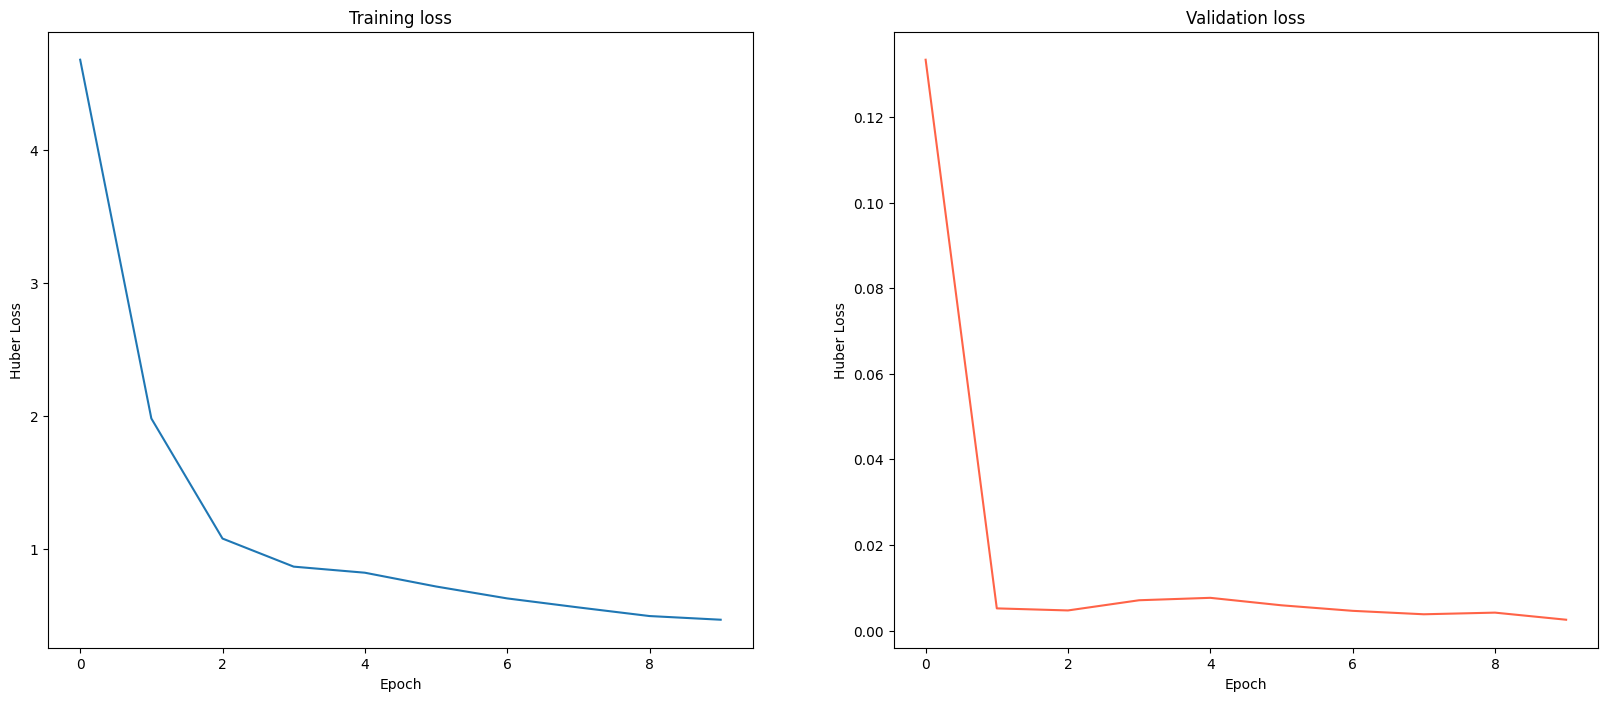

In [201]:
optimizer.param_groups[0]['lr']=1e-4

epoch_plot=[]
val_plot=[]
num_epochs=10
val_loss_record=1
# counter=0
# teacher_forcing_rate=0.9
for epoch in range(0, num_epochs):

    # Call train and validate 
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))
    
    curr_lr = float(optimizer.param_groups[0]['lr'])
    
    train_loss              = trainer.train()
    epoch_plot.append(train_loss)

    val_loss              = trainer.validate()

    val_plot.append(val_loss)

    if val_loss<val_loss_record:
      path = "/content/drive/MyDrive/stock_sft_teacher_SMA.pth"
      print("Saving model")
      torch.save({'model_state_dict':trainer.model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_loss': val_loss, 
                  'epoch': epoch}, path)
      val_loss_record = val_loss

  
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.08f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))

fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(epoch_plot)
ax[0].set_ylabel("Huber Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_plot, color='tomato')
ax[1].set_ylabel("Huber Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")




# Testing

In [202]:
gc.collect()
torch.cuda.empty_cache()

In [203]:
trainer=Trainer(model, train_loader, criterion, val_loader=val_loader, test_loader=test1_loader)
prediction1=trainer.test()
prediction1=np.array(prediction1).reshape(-1)
prediction1.shape 
# prediction=[i.cpu().detach().numpy() for i in prediction]

(930,)

In [204]:
trainer=Trainer(model, train_loader, criterion, val_loader=val_loader, test_loader=val_loader)
prediction=trainer.test()
prediction=np.array(prediction)
prediction=prediction.reshape(-1)
prediction.shape   

(9840,)

In [116]:
np.array(X_test).shape

(10000, 125)

### **Training set Plot**

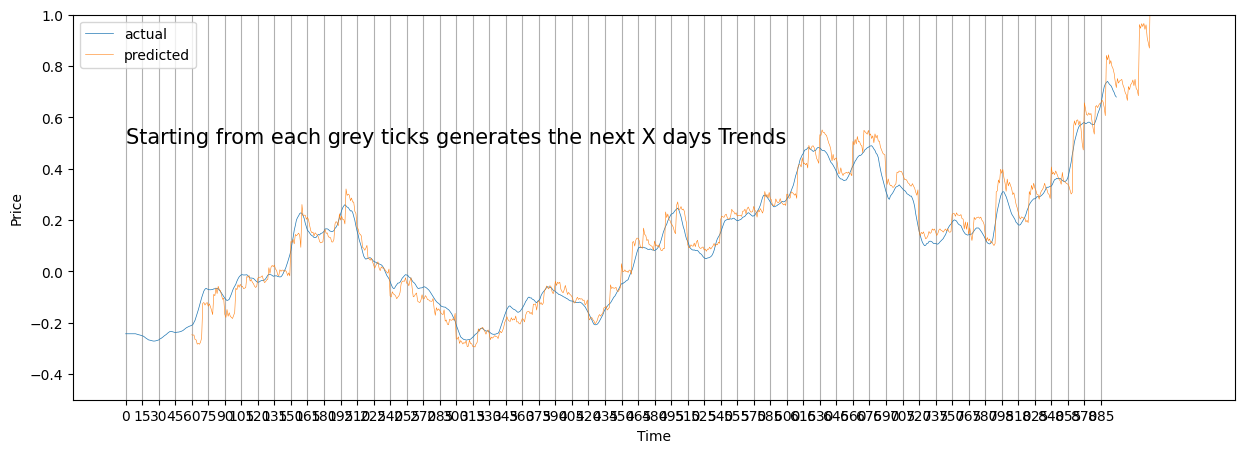

In [217]:
start=0
end=start+900
slice1=np.array(X_train[0:1000])[start:end,CLOSE]
plt.figure(figsize=(15,5))
plt.plot(slice1, label='actual', linewidth=0.5)
xx=np.arange(context_len, context_len+end-start)
plt.plot(xx, prediction1[start:end], label='predicted', linewidth=0.4)
plt.ylim(-0.5,1)
plt.legend()
plt.xticks(np.arange(0,end-start,15))
plt.ylabel("Price")
plt.xlabel("Time")
plt.grid(True, axis='x')
plt.annotate("Starting from each grey ticks generates the next X days Trends", xy=(0,0.5),fontsize=15)
plt.savefig("demo.png", transparent = False)
plt.show()

### **Test set Plot**

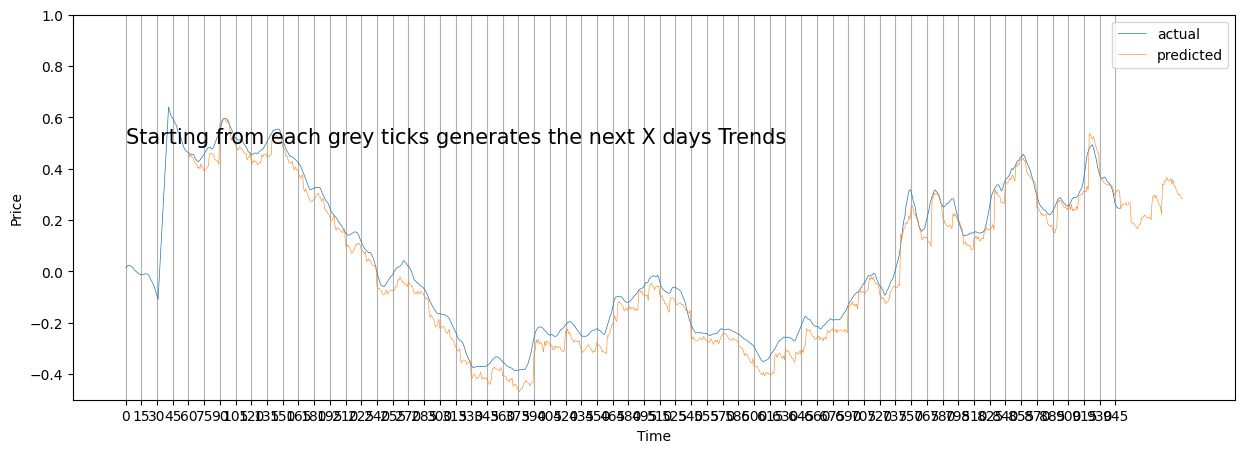

<Figure size 640x480 with 0 Axes>

In [218]:
start=0
end=start+950
slice1=np.array(X_test[0:1000])[start:end,CLOSE]
plt.figure(figsize=(15,5))
plt.plot(slice1, label='actual', linewidth=0.5)
xx=np.arange(context_len, context_len+end-start)
plt.plot(xx, prediction[start:end], label='predicted', linewidth=0.4)
plt.ylim(-0.5,1)
plt.legend()
plt.xticks(np.arange(0,end-start,15))
plt.ylabel("Price")
plt.xlabel("Time")
plt.grid(True, axis='x')
plt.annotate("Starting from each grey ticks generates the next X days Trends", xy=(0,0.5),fontsize=15)
plt.show()
plt.savefig("demo1.png", transparent = False)

In [ ]:
gc.collect()
torch.cuda.empty_cache()


In [ ]:
prediction_padded=np.pad(prediction,(context_len+1, pred_len),'constant', constant_values=(prediction[0], prediction[-1]))
# print(r2_score(np.array(dataset)[:,CLOSE], prediction_padded))

In [ ]:
prediction_padded.shape

(1334,)

In [ ]:
actual_data=Scaler.inverse_transform(dataset_standard)
print(actual_data)

[[ 1.00000000e+00  0.00000000e+00  9.17000000e+00 ... -4.25978072e-02
  -2.66890839e-02 -2.74211300e-02]
 [ 1.00000000e+00  1.00000000e+00  9.16000000e+00 ... -4.45235238e-02
  -4.29711724e-02 -4.45133162e-02]
 [ 1.00000000e+00  2.00000000e+00  9.11000000e+00 ... -4.09432172e-02
  -2.83227810e-02 -2.71107186e-02]
 ...
 [ 1.00000000e+00  1.33100000e+03  1.21600000e+01 ...  3.07563614e+00
  -3.57337801e-01  4.73962836e-01]
 [ 1.00000000e+00  1.33200000e+03  1.20000000e+01 ...  2.57709663e+00
  -3.72003760e-01  4.02557744e-02]
 [ 1.00000000e+00  1.33300000e+03  1.20900000e+01 ...  2.79284306e+00
  -2.05171904e-01  6.87277506e-02]]


In [ ]:
# dataset_standard_copy=dataset_standard.copy()
# dataset_standard_copy[:,CLOSE]=prediction_padded
# predict_data=Scaler.inverse_transform(dataset_standard_copy)

In [222]:
# plt.figure(figsize=(20,6))
# plt.plot(np.array(actual_data)[:,CLOSE], label='Actual Price', color='darkorange', linewidth=1)
# # plt.plot(np.array(actual_data)[:,7], label='Moving Average', color='cyan')
# # plt.bar(x=np.arange(0,len(dataset)), height=np.array(actual_data)[:,4]/5000000 , label='Volume', color='lightskyblue', alpha=0.3)

# plt.plot( predict_data[:,CLOSE], label='Predicted Price',color='royalblue', linewidth=1)
# plt.axvline(x = int(len(dataset)*0.7), color='r', label="Model Blind-Generated After")
# plt.legend()
# plt.xlabel("Days")
# plt.ylabel("Prices")
# plt.annotate("STOCK",xy=(0.3,70),textcoords='offset points', fontsize=30)
# # plt.savefig("STOCK.png", transparent = False)

In [220]:
# plt.figure(figsize=(20,6))
# plt.plot(np.array(actual_data)[900:1000,CLOSE], label='Actual Price', color='darkorange', linewidth=1)
# # plt.plot(np.array(actual_data)[:,7], label='Moving Average', color='cyan')
# # plt.bar(x=np.arange(0,len(dataset)), height=np.array(actual_data)[:,4]/5000000 , label='Volume', color='lightskyblue', alpha=0.3)

# plt.plot( predict_data[900:1000,CLOSE], label='Predicted Price',color='royalblue', linewidth=1)
# # plt.axvline(x = int(len(dataset)*0.7), color='r', label="Model Blind-Generated After")
# plt.legend()
# plt.xlabel("Days")
# plt.ylabel("Prices")
# plt.annotate("STOCK",xy=(0.3,70),textcoords='offset points', fontsize=30)
# plt.xticks(np.arange(0,len(predict_data[900:1000,CLOSE]),1))
# plt.grid(True)
# plt.show()
# # plt.savefig("STOCK.png", transparent = False)

In [ ]:
# plt.savefig("AAPL1.png", transparent = False)

<Figure size 640x480 with 0 Axes>

In [ ]:
# import pandas as pd

In [221]:
# dff=pd.DataFrame(predict_data[:,3], columns=['Pred_Close'])
# dff.to_csv("AAPL_pred.csv")
# dff

In [ ]:
# #window size: 65, context_len:5, pred_len: 5 
# pp=[]
# pbar = tqdm(total=800,desc="predicting...")
# for i in range(800):
#   query=dataset[context_len-1+i:window_size-1+i]
#   tar=torch.FloatTensor(query).unsqueeze(0).to(device)   #1,5, 9
#   src=torch.FloatTensor(dataset[0+i: context_len+i]).unsqueeze(0).to(device)   #1, 65,9

#   out=trainer.model(src,tar) 
#   o=out.cpu().detach().numpy()[0,1]  
#   pp.append(o)
#   pbar.update()
# pbar.close()
# pp=np.squeeze(pp)
# pp.shape

In [ ]:
# #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
# plt.figure(figsize=(10,8))
# plt.plot(np.array(dataset)[:1100,4], label='Actual Price', color='darkorange', linewidth=1)
# plt.plot(np.array(dataset)[:1100,8], label='Moving Average', color='cyan')
# plt.bar(x=np.arange(0,1100), height=np.array(dataset)[:1100,5]/5, label='Volume', color='lightskyblue', alpha=0.3)
# plt.annotate("GOOGL",xy=(0.3,0.6),textcoords='offset points')
# plt.plot(np.arange(context_len,800+context_len), pp, label='Predicted Price',color='royalblue', linewidth=0.5)
# plt.legend()
# # plt.ylim(200,400)

In [ ]:
# import seaborn as sns

In [208]:
# def test_for_agent( model, test_loader):
#       model.eval() # set to training mode
#       model.to(device)
#       batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
#       prediction=[]
#       for i, batch in enumerate(test_loader):
#           # self.optimizer.zero_grad()

#           src, trg, y_test = batch

#           src = src.to(device)
#           trg = trg.to(device)

#           batch_size = src.shape[0]

#           y_pred = model(src, trg, src_mask=None, tgt_mask=None)
#           prediction.append(y_pred[0])

#           #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
#           del src, trg, y_test
#           torch.cuda.empty_cache()
#           batch_bar.update()

#       batch_bar.close()

#       return prediction

In [219]:
# prediction=test_for_agent(model=trainer.model, test_loader=test_loader)
# prediction=[i.cpu().detach().numpy() for i in prediction]
# prediction

In [ ]:
# prediction=np.squeeze(np.array(prediction))
# prediction.shape

(1217, 10)

In [ ]:
# prediction=prediction[int(0.5*len(dataset)):]


In [ ]:
# pred_data=Scaler.inverse_transform(prediction)
# plt.plot(pred_data[:,0])

# Experiment

In [ ]:
# Login to Wandb
# Initialize your Wandb Run Here
# Save your model architecture in a txt file, and save the file to Wandb

In [ ]:
# Optional: Load your best model Checkpoint here

# TODO: Create a testing function similar to validation 
# TODO: Create a file with all predictions 
# TODO: Submit to Kaggle